In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mhm_dataprocessing import *

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

### Read data

In [2]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")

#shapefile mask
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")

In [3]:
be_data = clip_to_region(be_shp, mhm_fluxes)

#resample to month ends
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SM_Lall','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= be_data[variables].resample(time='ME').mean()

In [ ]:
mhm_fluxes_mon

In [ ]:
#select values for June
data=mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month==6)

#select a time series from a specific location
sample_ts = mhm_fluxes_mon['SM_Lall'].sel(lon=4.5, lat=50.5, method='nearest')

In [ ]:
ts_df = sample_ts.to_dataframe().drop(columns=['lat', 'lon'])

In [ ]:
fig,ax=plt.subplots(figsize=(10,2.5))
plt.plot(ts_df.index, ts_df['SM_Lall'])
plt.axhline(y=0.73, color='r', linestyle='--')

#### SMI and drought characteristics

ref: https://www.nature.com/articles/s41558-018-0138-5

$SMI_{t} = F_{T}(x_{t})$


 Represents the quantile at the soil moisture fraction value x (normalized against the saturated soil water content). x t denotes the simulated monthly soil moisture fraction at a time t and is the empirical distribution function estimated using the kernel density estimator, $f_{t}(x)$

 $f_{t}(x) = \frac{1}{nh}\sum_{k=1}^{n}K(\frac{x-x_{k}}{h})$
  

 Here, $x_{1}$, …, $x_{n}$ n represents the simulated soil moisture fraction of a given calendar month during the reference period T; n denotes the number of calendar months within a given period (that is, 30 for a 30-year period); and $K$ represents a Gaussian kernel function with a bandwidth h. The bandwidth is estimated with GridSearch.
 
$K(x, x_{k}) = \frac{1}{\sqrt{2\pi h^{2}}}\exp(\frac{(x-x_{k})^{2}}{2h^{2}})$

A cell at time t is under drought when SMI t  < $\tau$. Here, $\tau$ denotes that the soil water content in this cell is less than the values occurring $\tau$ × 100% of the time. In this study, τ is set to 0.2
 

  
### Bandwidth selection
Find the optimal bandwidth h for the distribution function.
GridsearchCV

-- --
Alternatively using Silverman's rule (has limitations)


https://towardsdatascience.com/bounded-kernel-density-estimation-2082dff3f47f

Silverman's rule of thumb, optimal when the underlying density being estimated is Gaussian

$h = \sigma * (\frac{4}{3n})^{-0.2}$

#### Kernel Density Estimation (Example)

In [ ]:
#GridSearchCV to find the optimal bandwidth
#extract values
soil_moisture = ts_df.values[:,0]
# Define a range of bandwidths to test
bandwidths =np.linspace(0.001, 0.9, 500)

# Perform cross-validated grid search for bandwidth h
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(soil_moisture[:, None])

# Optimal bandwidth
optimal_h = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {optimal_h}")

#///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# kernel density estimation
kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
kde.fit(soil_moisture[:, None]) #fit the KDE model to the data

#plot the kde
x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, 1000) 
#x used for evaluating the kernel density estimation (KDE) does not have to be the same as the original data points.
#  Instead, x is typically chosen as a smooth, evenly spaced range of values that covers the domain of the data.
#  This ensures that the KDE curve is displayed smoothly over the range of interest.
# x is for the visualization of the KDE, not for determining the underlying probabilities of your data

#evaluate the KDE at the x values
#range of soil moisture values
logprob = kde.score_samples(x[:, None]) #log of the probability density function

#probability density function
prob_density = np.exp(logprob)

#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


#plot the KDE
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.fill_between(x, prob_density, alpha=0.5)
#plot vertical lines (|) representing the soil moisture values, with height equal to -0.01
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)
plt.xlabel('sm')
plt.ylabel('Probability Density')

### Cumulative distribution function

Integrate the probability distribution function to obtain the CDF

In [ ]:
# Compute the CDF by integrating the PDF
cdf = np.cumsum(prob_density) * (x[1] - x[0])

In [ ]:
### calculare the probability of soil moisture being below 0.71
cdf_071 = np.interp(0.732, x, cdf)

#calculate the sm value corresponding to 0.2 cumulative probability
sm_02 = np.interp(0.2, cdf, x)
sm_02

In [ ]:
# Plot the PDF and CDF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, prob_density, label='PDF')
plt.axvline(sm_02, color='red', lw=0.5, label='20%')
plt.xlabel('Soil Moisture')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='CDF', color='orange')
plt.axvline(sm_02, color='red', lw=0.5, label='20%')
#fill between the x values up to the threshold value
plt.fill_between(x, cdf, where=(x <= sm_02), color='red', alpha=0.)

plt.xlabel('Soil Moisture')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.tight_layout()
plt.show()

### Soil Moisture Index for entire dataset

In [ ]:
#Period of interest. In this case, summer months
summer_months = [6,7,8]
#extract values for summer months
data_summer = mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month.isin(summer_months))

#average soil moisture for summer months for each year
data_summer_avg = data_summer.groupby('time.year').mean()

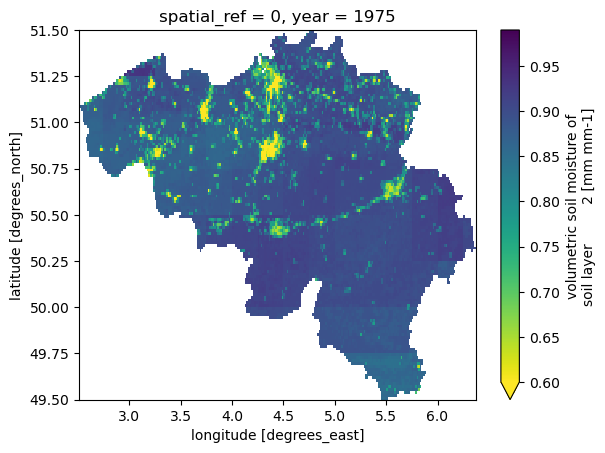

In [9]:
data_summer_avg['SM_L02'][5].plot(vmin=0.6, vmax=0.99, cmap='viridis_r')

In [ ]:
variable = 'SM_L02'
# Define the x-axis range for KDE (fixed for consistency across grid cells)
cdf_length = 200  # Number of points for the CDF
cdf_x = None  # To store the x-axis values for the CDF (soil moisture range)

# Initialize a 3D array for storing the CDFs
cdf_array = np.full((len(data_summer_avg.lat), len(data_summer_avg.lon), cdf_length), np.nan)

# Loop through the grid cells
for i in range(len(data_summer_avg.lon)):  # Longitude dimension
    for j in range(len(data_summer_avg.lat)):  # Latitude dimension
        # Extract the time series for the current grid cell
        sample_ts = data_summer_avg[variable].sel(
            lon=data_summer_avg.lon[i], 
            lat=data_summer_avg.lat[j], 
            method='nearest'
        )
        ts_df = sample_ts.to_dataframe()
        soil_moisture = ts_df[variable].values

        # Skip cells with all NaN values
        if np.isnan(soil_moisture).all():
            continue

        # Compute optimal bandwidth for KDE
        bandwidths = np.linspace(0.001, 0.9, 200)
        optimal_h = compute_optimal_h(soil_moisture, bandwidths)

        # Perform KDE
        kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
        kde.fit(soil_moisture[:, None])

        # Define x-axis range for CDF
        if cdf_x is None:  # Initialize x-axis range if not already set
            cdf_x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, cdf_length)

        logprob = kde.score_samples(cdf_x[:, None])
        prob_density = np.exp(logprob)

        # Compute the CDF
        cdf = np.cumsum(prob_density) * (cdf_x[1] - cdf_x[0])

        # Store the CDF in the corresponding grid cell
        cdf_array[j, i, :] = cdf


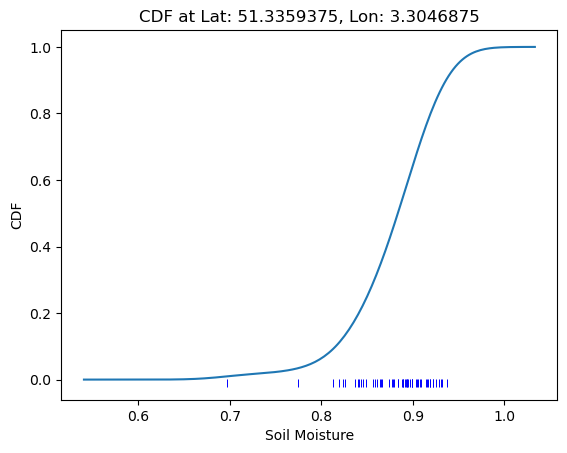

In [160]:
lat_idx = 10
lon_idx = 50
#extract sm values for the selected grid cell
sample_ts = data_summer_avg['SM_L02'].sel(lon=data_summer_avg.lon[lon_idx], lat=data_summer_avg.lat[lat_idx], method='nearest')
ts_df = sample_ts.to_dataframe()
soil_moisture = ts_df['SM_L02'].values


plt.plot(cdf_x, cdf_array[lat_idx, lon_idx, :])
#plot soil moisture values
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)


plt.title(f"CDF at Lat: {data_summer_avg.lat[lat_idx].values}, Lon: {data_summer_avg.lon[lon_idx].values}")
plt.xlabel("Soil Moisture")
plt.ylabel("CDF")
plt.show()


In [146]:
import xarray as xr

lat_vals = data_summer_avg.lat.values
lon_vals = data_summer_avg.lon.values

# Create an xarray DataArray for the 3D CDF array
cdf_data = xr.DataArray(
    data=cdf_array,
    coords={"lat": lat_vals, "lon": lon_vals, "cdf_x": cdf_x},
    dims=["lat", "lon", "cdf_x"]
)

# Save to NetCDF
#cdf_data.to_netcdf("soil_moisture_cdf_3d.nc")


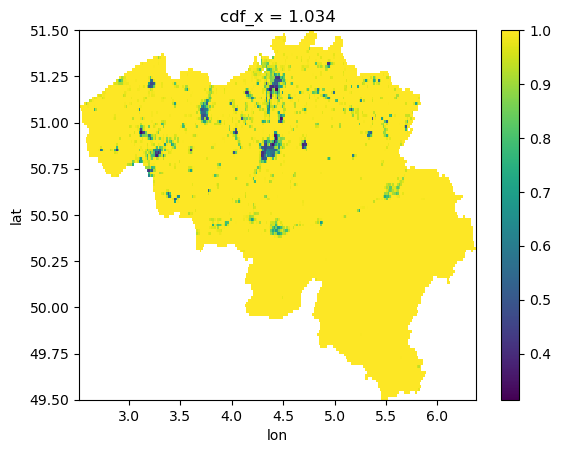

In [157]:
cdf_data[:, :, -1].plot()

Text(0, 0.5, 'Probability Density')

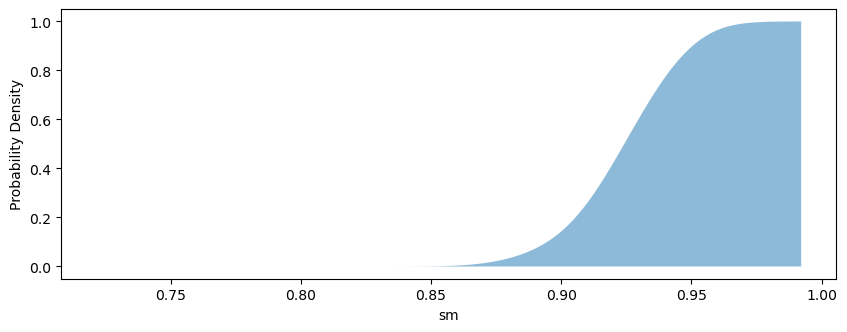

In [155]:
#plot the KDE
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.fill_between(x, cdf, alpha=0.5)
#plot vertical lines (|) representing the soil moisture values, with height equal to -0.01
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)
plt.xlabel('sm')
plt.ylabel('Probability Density')

#### Map the each cdf to the corresponding coordinates